In [89]:
import numpy as np
from distance import *
from MCMC import * 
import pandas as pd
import matplotlib.pyplot as pl
from sklearn.neighbors import KernelDensity

def plot_contours(X,Y,Z,ax,cmap='Grays',xi2_levels=np.array([11.829,6.1801,2.2977,0]),color='r',colormap='Reds',label=r"$\mathrm{Pantheon}$"):
    
    levels = np.max(Z) - xi2_levels/2
    i,j = np.unravel_index(np.argmax(Z), np.array(Z).shape)
    ax.contourf(X,Y,Z,levels=levels,alpha=.5,cmap=colormap)
    ax.text(X[i,j]+0.1,Y[i,j]+0.1,s=label,rotation=45,fontsize=15,color=color)

    return fig

    
def plot_cosmo():
    
    fig = pl.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    
    ax.plot([0,1],[1,0],linestyle='--',c='k')
    ax.plot([0,1.2],[0,0.6],linestyle='--',c='k')
    ax.set_xlabel(r'$\Omega_m$',size=27)
    ax.set_ylabel(r'$\Omega_\Lambda$',size=27)
    fig.text(0.37,0.37,s='Flat universe',rotation=-45,fontsize=20,color='k')
    fig.text(0.2,0.13,s='Expanding universe',rotation=np.arctan(0.5)*360/(2*np.pi),fontsize=20,color='k')
    
    ax.set_title('oCDM Constrains For SN-only Sample.',size=22)
    ax.set_xlim(0,1.2)
    ax.set_ylim(0,1.2)
    
    return fig,ax
    

- Data: $X_i \equiv (\mu_i, z_i)$

- Cosmological parameters: ${\Omega} = {\Omega_{\Lambda}, \Omega_{m}, \Omega_{k}}$

- Likelihood: $$P( \vec X| \Omega_m, \Omega_{\Lambda}, \Omega_k) \propto \exp \left( -\frac{1}{2}\Delta \vec \mu \cdot C^{-1} \cdot \Delta \vec \mu\right)$$

where
$\Delta  \mu_{i} = \mu_{i} -  \mu_{model}(z_i; \Omega)$

# Loading data


In [40]:
data=pd.read_csv('lcparam_DS17f.txt',delimiter=' ')
cov_data = np.array(pd.read_csv('sys_DS17f.txt'))

# create numpy version data
red_shift_data = (data['zcmb']).to_numpy()
apparent_magnitude_data = (data['mb']).to_numpy() 
apparent_magnitude_standard_errors = (data['dmb']).to_numpy()
stat_cov = np.diag(apparent_magnitude_standard_errors**2.)
sys_cov = cov_data.reshape(40, 40)
cov_sys_matrix = stat_cov + sys_cov
cov_matrix = stat_cov

inv_sys_cov=  np.linalg.inv(cov_sys_matrix)
inv_cov = np.linalg.inv(cov_matrix)




# Plotting Covariance


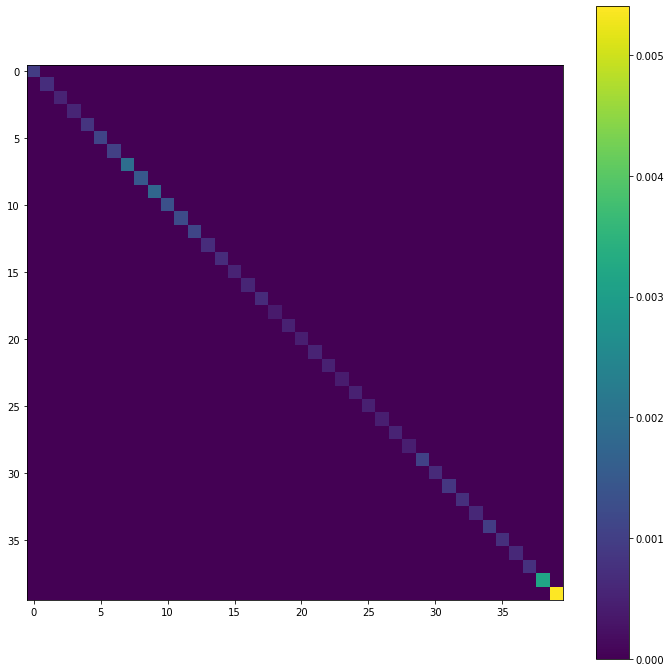

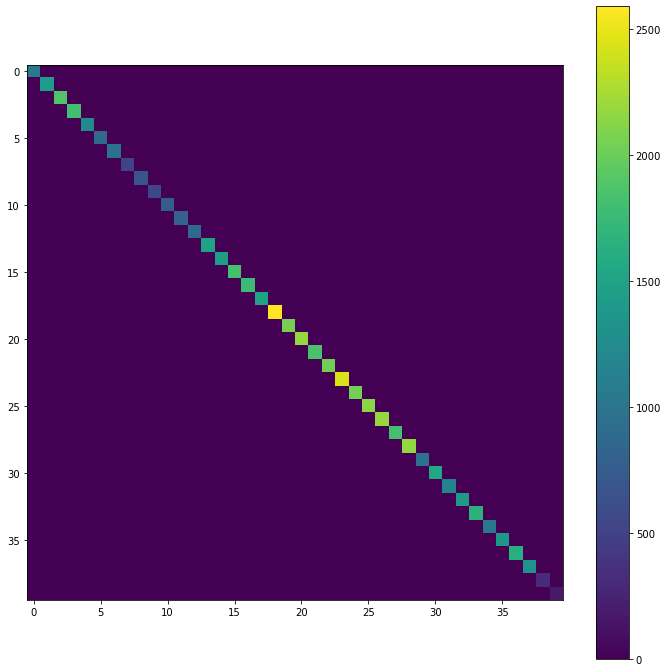

In [41]:
pl.figure(figsize=(12,12))
pl.imshow(cov_matrix)
pl.colorbar()

pl.figure(figsize=(12,12))
pl.imshow(inv_cov)
pl.colorbar()


# Test distance modulus


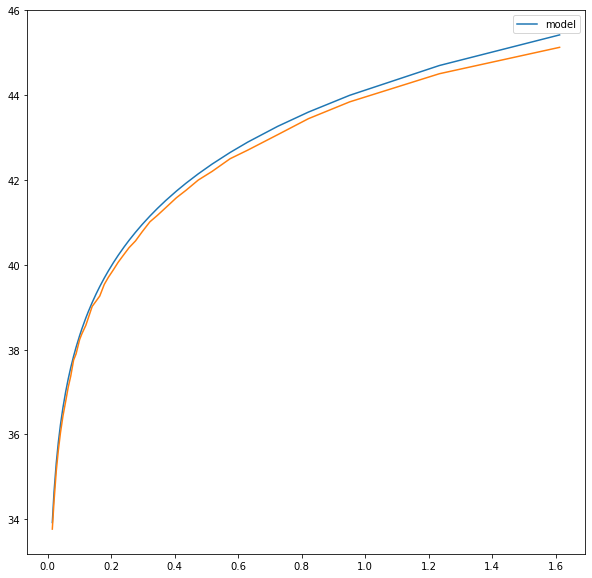

In [10]:

mu_model = distance_modulus(red_shift_data,.286,.714,69.6,1E2)
M = -19.2

pl.figure(figsize=(10,10))
pl.plot(red_shift_data,mu_model,label='model')
pl.plot(red_shift_data,apparent_magnitude_data-M)
pl.legend()

# Run MCMC

In [67]:
pars_label = [r'$\Omega_m$',r'$\Omega_{\Lambda}$',r'$H_0$']
nwalkers = 10
cov_gen = np.diag([0.1**2.,0.1**2.,5**2.])
chains_stat = []
chains_sys = []
nsteps = 10000

for n in range(nwalkers):
    
    Omegas = np.random.uniform(0,[1,1,100],3)
    
    chain_stat = run_MCMC(red_shift_data,apparent_magnitude_data,cov_matrix,p0=Omegas,cov_gen=cov_gen,nsteps=nsteps)
    chain_sys  = run_MCMC(red_shift_data,apparent_magnitude_data,cov_sys_matrix,p0=Omegas,cov_gen=cov_gen,nsteps=nsteps)

    chains_stat.append(chain_stat)
    chains_sys.append(chain_sys)
    
stacked_chain_sys = np.vstack(np.array(chains_sys))
stacked_chain_stat = np.vstack(np.array(chains_stat))

/home/dustspeck/Downloads/Spring2022/PHY250/H0llyM0lly/distance.py:78: RuntimeWarning: invalid value encountered in log10
  return 5*np.log10(luminosity_distance) + 25


# PLOT CHAINS

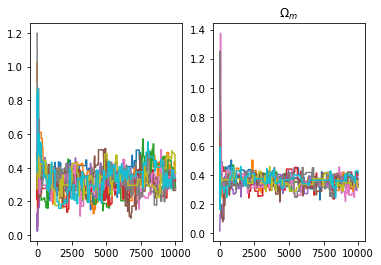

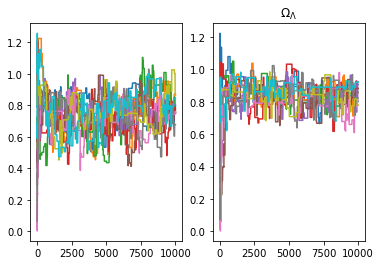

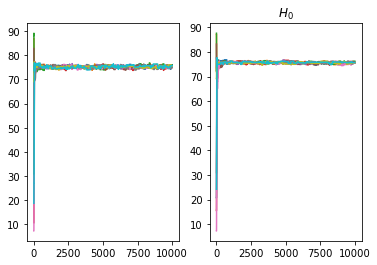

In [68]:
    
for i in range(chain.shape[1]):
    f = pl.figure()
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    for chain in chains_sys:
        c = chain[:,i]
        n = range(chain.shape[0])
        ax.plot(n,c)
    for chain in chains_stat:
        c = chain[:,i]
        n = range(chain.shape[0])
        ax2.plot(n,c)

    
    pl.title(pars_label[i])
    

# Get posterior surface and plot contours

<ipython-input-81-50c5ebb2e651>:7: RuntimeWarning: divide by zero encountered in log
  H = np.log(H.T/H.sum())


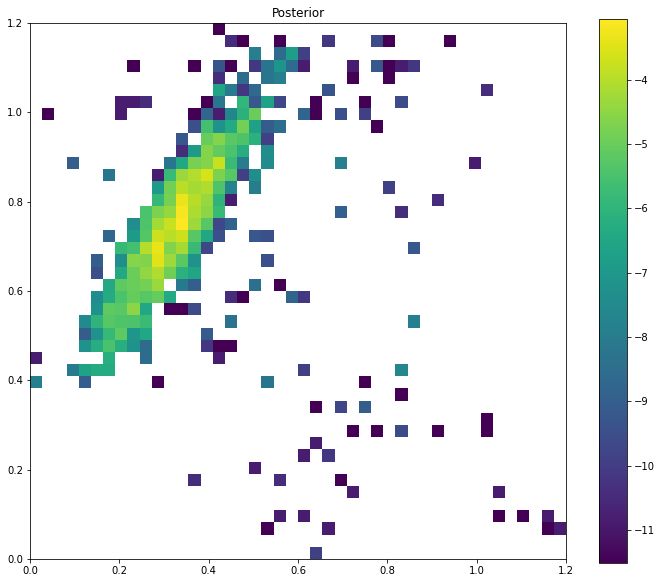

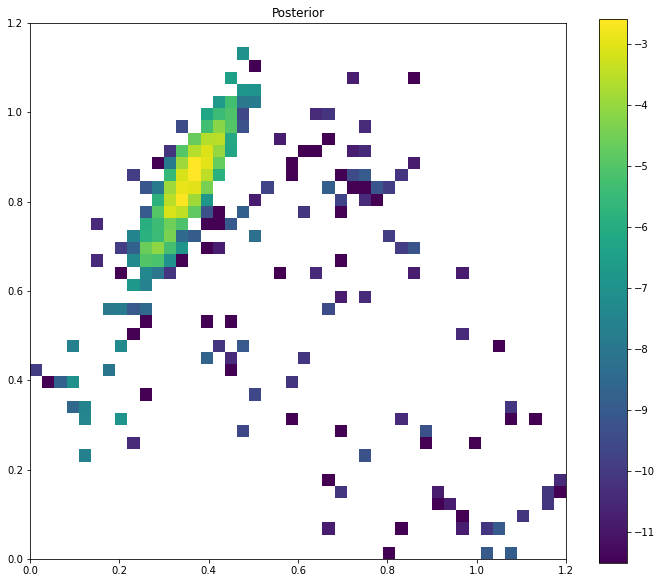

In [81]:
Hs = []
for stacked_chain in [stacked_chain_sys,stacked_chain_stat]:
    
    x,y = stacked_chain[:,0],stacked_chain[:,1]
    edges = np.linspace(0,1.2,45)
    H, xedges, yedges = np.histogram2d(x, y,bins=(edges,edges))
    H = np.log(H.T/H.sum())
    Hs.append(H)

    fig = pl.figure(figsize=(12, 10))

    ax = fig.add_subplot(111, title='Posterior')

    pl.imshow(H, interpolation='nearest', origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

    pl.colorbar()
    


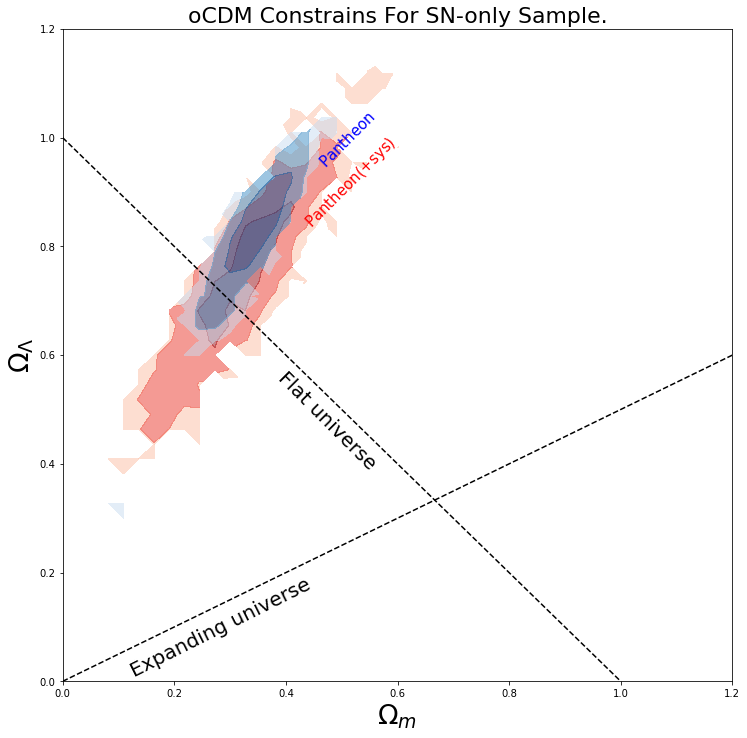

In [90]:
X, Y = np.meshgrid(edges[0:-1],edges[0:-1])
fig,ax = plot_cosmo()
colormaps = ['Reds','Blues']
labels = [r"$\mathrm{Pantheon(+sys)}$",r"$\mathrm{Pantheon}$"]
colors = ['r','b']
for i in range(2):

    plot_contours(X,Y,Hs[i],ax,colormap=colormaps[i],color=colors[i],label=labels[i])
    

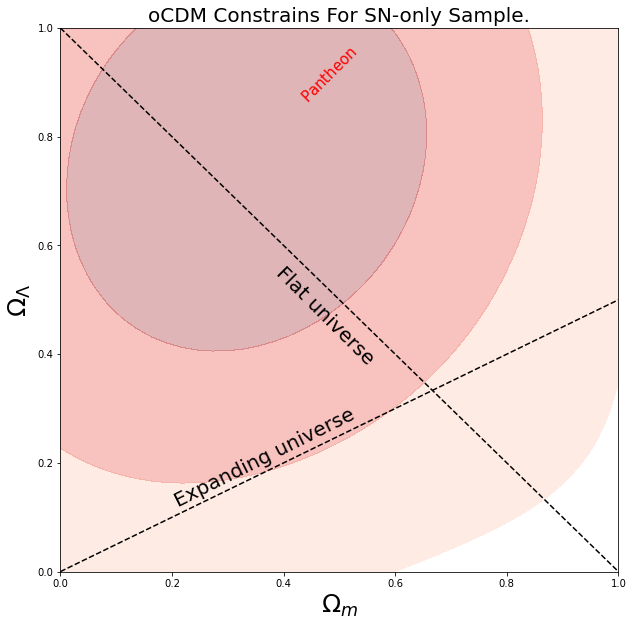

In [36]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.vstack([y, x]).T)
xy = np.vstack([Y.ravel(), X.ravel()]).T

z = kde.score_samples(xy)
Z = np.reshape(z, X.shape)
plot_contours(X,Y,Z)
